# Capstone Project 1: Data Wrangling

**Our Problem:** 

Can emails be used to identify the author's gender?

## Overview
For this notebook, our **goal** will be to Acquire, Wrangle, and Clean data from the Enron email dataset.

## I. Acquiring the Data
The data we'll be working with comes in two forms:
- The Enron email dataset
- Assumed gender by name

The Enron email dataset we'll be working with can be downloaded online from the Carnegie Mellon University School of Computer Science (https://www.cs.cmu.edu/~./enron/) as of March 28, 2020. It comes convieniently zipped under the filename `enron_mail_20150507.tar.gz`.

To collect the assumed genders, by name, we'll need to isolate the sender names and decide on a method of identifying gender. We'll return to this once the dataset is cleaned.

### Acquiring the Data: Enron Emails

Once unzipped, the initial file is `maildir`; we'll call this the *mail directory* (I know - creative). The hierarchy in this file directory goes as such:
- Mail Directory ('maildir')
 - Employee Email Folders
  - disorganized mess (folders + emails)

Let's use the `os` library to explore the directory with its function `os.scandir()`. We'll evaluate each object returned by `os.scandir()`; if it is another folder, we'll `.append()` it to our list so it will also get explored.

Once all the folders have been collected, the second part of the function will iterate through the complete `folder_list` and compile a `file_list` of email file names.

In [ ]:
import os

# setup function to return filenames from directory
def file_grabber(some_directory):
    """Returns all files from directory
    and child directories by creating, appending
    a directory list until all directories are located.
    
    Then, cycles through each directory and records any
    filenames to a list. This list is returned on completion."""
    
    # initialize folder list
    folder_list = []

    # appends starting folder to folder list
    folder_list.append(some_directory)
    
    # iterate through folder list
    for folder in folder_list:
        
        # open content manager with .scandir() on folder
        with os.scandir(folder) as open_folder:

            # for each item in the directory folder
            for thing in open_folder:

                # if the thing is another folder
                if thing.is_dir():
                    thing_path = (folder + thing.name + '/')
                    folder_list.append(thing_path)
                else:
                    continue
      
    # print out number of folders
    print('{} folders found.'.format(len(folder_list)))
    
    # initialize file list
    file_list = []
    
    # iterate through folder list to collect filenames
    for folder in folder_list:
        
        # open content manager with .scandir() on folder
        with os.scandir(folder) as open_folder:

            # for each item in the directory folder
            for thing in open_folder:

                # if the thing is another folder
                if thing.is_file():
                    thing_path = (folder + thing.name)
                    file_list.append(thing_path)
                else:
                    continue
                
    # print out report                    
    print('{} files found.'.format(len(file_list)))
    
    # return files as list
    return file_list

***Function complete.*** Now, let's put it into action!

In [2]:
# initialize list to collect filenames
email_files = []

# create base string
base_name = './data/maildir/'
    
# call function to collect file names
email_files = file_grabber(base_name)

3500 folders found.
517401 files found.


***Nice!*** 517401 files found! Let's sort the list and look at some of the filepaths returned.

In [3]:
# sort the list
email_files.sort()

# take a peek
email_files[:5]

['./data/maildir/allen-p/_sent_mail/1',
 './data/maildir/allen-p/_sent_mail/10',
 './data/maildir/allen-p/_sent_mail/100',
 './data/maildir/allen-p/_sent_mail/1000',
 './data/maildir/allen-p/_sent_mail/1001']

## II. Wrangling the Data

> Data Wrangling:
>
> "The process of transforming and mapping data from one "raw" data form into another format with the intent of making it more appropriate and valuable for a variety of downstream purposes such as **analytics**." - Wikipedia, Data wrangling

Let's begin by exploring the *current state of the data*. We'll make notes, and decide what ***wrangling*** we'll need to do. 

The dataset itself is over 0.5M emails, comes as a *bunch of folders* containing a **bunch of emails** and the unzipped form we'll be working with weighs in around 1.4GB. Let's review an email and isolate some parts to wrangle.

In [4]:
# email reader
def read_email(email_path):
    """returns email body as a body of text"""
    
    # file manager opens email file, assigns it to variable
    with open(email_path) as email_file:
        email_body = email_file.read()
    
    # returns email body as text
    return email_body

In [5]:
# email text by line as list
print(read_email(email_files[10]))

Message-ID: <33076797.1075855687515.JavaMail.evans@thyme>
Date: Mon, 16 Oct 2000 06:42:00 -0700 (PDT)
From: phillip.allen@enron.com
To: buck.buckner@honeywell.com
Subject: Re: FW: fixed forward or other Collar floor gas price terms
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: "Buckner, Buck" <buck.buckner@honeywell.com> @ ENRON
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Dec2000\Notes Folders\'sent mail
X-Origin: Allen-P
X-FileName: pallen.nsf

Mr. Buckner,

 For delivered gas behind San Diego, Enron Energy Services is the appropriate 
Enron entity.  I have forwarded your request to Zarin Imam at EES.  Her phone 
number is 713-853-7107.  

Phillip Allen


### ***To evaluate our problem,*** we need gender and email text.

From the email above, we'll collect the `From:` field to capture names (and subsequently, make some assumptions on gender). We'll also need to isolate the email body from the rest of the header information contained in the file. Finally, to keep the data subsets tied to their original forms, we'll preserve the file directory name as an index. 

Let's tackle this goal in two steps:
- Collect the variables of interest in a dictionary using the `re` library
- Convert the dictionary to a DataFrame using `pd.DataFrame.from_dict()`



In [6]:
# libraries
import re

# custom function
def save_to_dict(email_path):
    """create dictionary from a list of filepath files
       returns dictionary"""

    # open email file, get email text
    with open(email_path) as open_email:
        
        # get file text
        email_text = open_email.read()
        
        # get 'Message-ID'
        m_id = ''
        catch = m_id_pat.search(email_text)
        if catch:
            m_id = catch[0]         
    
        # get 'Date'
        m_date = ''
        catch = m_date_pat.search(email_text)
        if catch:
            m_date = catch[0]     
        
        # get 'From'
        m_from = ''
        catch = m_from_pat.search(email_text)
        if catch:
            m_from = catch[0] 
        
        # get 'To'
        m_to = ''
        catch = m_to_pat.search(email_text)
        if catch:
            m_to = catch[0] 

        # get 'Cc'
        m_cc = ''
        catch = m_cc_pat.search(email_text)
        if catch:
            m_cc = catch[0] 
        
        # get 'Bcc'
        m_bcc = ''
        catch = m_bcc_pat.search(email_text)
        if catch:
            m_bcc = catch[0] 

        # get 'Subject'
        m_subj = ''
        catch = m_subj_pat.search(email_text)
        if catch:
            m_subj = catch[0] 

        # get 'Mime-Version'
        mime_vers = ''
        catch = mime_vers_pat.search(email_text)
        if catch:
            mime_vers = catch[0] 

            # get 'Content-Type'
        cont_type = ''
        catch = cont_type_pat.search(email_text)
        if catch:
            cont_type = catch[0] 

        # get 'Content-Transfer-Encoding'
        encode = ''
        catch = encode_pat.search(email_text)
        if catch:
            encode = catch[0] 

        # get 'X-From'
        x_from = ''
        catch = x_from_pat.search(email_text)
        if catch:
            x_from = catch[0] 

        # get 'X-To'
        x_to = ''
        catch = x_to_pat.search(email_text)
        if catch:
            x_to = catch[0] 

        # get 'X-cc'
        x_cc = ''
        catch = x_cc_pat.search(email_text)
        if catch:
            x_cc = catch[0] 

        # get 'X-bcc'
        x_bcc = ''
        catch = x_bcc_pat.search(email_text)
        if catch:
            x_bcc = catch[0] 

        # get 'X-Folder'
        x_fold = ''
        catch = x_fold_pat.search(email_text)
        if catch:
            x_fold = catch[0] 

        # get 'X-Origin'
        x_orig = ''
        catch = x_orig_pat.search(email_text)
        if catch:
            x_orig = catch[0] 

        # get 'X-Filename'
        x_fname = ''
        catch = x_fname_pat.search(email_text)
        if catch:
            x_fname = catch[0]
    
        # get body
        m_body = ''
        catch = m_body_pat.split(email_text, 1)
        if catch:
            m_body = catch[1]
        
        # create dictionary entry
        wrangle_dict[email_path] = [m_id, m_date, m_from, m_to, 
                                    m_cc, m_bcc, m_subj, mime_vers, 
                                    cont_type, encode, x_from, x_to, 
                                    x_cc, x_bcc, x_fold, x_orig, 
                                    x_fname, m_body]

In [7]:
%%time
# import re library
import re
import concurrent.futures

# set regex patterns 'Message-ID'
m_id_pat = re.compile('(?<=Message-ID: )[^\n]*')

# set regex patterns 'Date'
m_date_pat = re.compile('(?<=\nDate: )[^\n]*')
    
# set regex patterns 'From'
m_from_pat = re.compile('(?<=\nFrom: )[^\n]*')

# set regex patterns 'To'
m_to_pat = re.compile('(?<=\nTo: )[^\n]*')

# set regex patterns 'Cc'
m_cc_pat = re.compile('(?<=\nCc: )[^\n]*')

# set regex patterns 'Bcc'
m_bcc_pat = re.compile('(?<=\nBcc: )[^\n]*')

# set regex patterns 'Subject'
m_subj_pat = re.compile('(?<=\nSubject: )[^\n]*')

# set regex patterns 'Mime-Version'
mime_vers_pat = re.compile('(?<=\nMime-Version: )[^\n]*')

# set regex patterns 'Content-Type'
cont_type_pat = re.compile('(?<=\nContent-Type: )[^\n]*')

# set regex patterns 'Content-Transfer-Encoding'
encode_pat = re.compile('(?<=\nContent-Transfer-Encoding: )[^\n]*')

# set regex patterns 'X-From'
x_from_pat = re.compile('(?<=\nX-From: )[^\n]*')

# set regex patterns 'X-To'
x_to_pat = re.compile('(?<=\nX-To: )[^\n]*')

# set regex patterns 'X-cc'
x_cc_pat = re.compile('(?<=\nX-cc: )[^\n]*')

# set regex patterns 'X-bcc'
x_bcc_pat = re.compile('(?<=\nX-bcc: )[^\n]*')

# set regex patterns 'X-Folder'
x_fold_pat = re.compile('(?<=\nX-Folder: )[^\n]*')

# set regex patterns 'X-Origin'
x_orig_pat = re.compile('(?<=\nX-Origin: )[^\n]*')

# set regex to return X-Filename, email body
x_fname_pat = re.compile('(?<=\nX-FileName: )[^\n]*\n\n')

# set regex patterns 'Body'
m_body_pat = re.compile('\nX-FileName: [^\n]*\n\n')

# initialize dictionary
wrangle_dict = {}

# concurrent futures executor
with concurrent.futures.ThreadPoolExecutor() as executor:  
    future = executor.map(save_to_dict, email_files)


Wall time: 5min 33s


In [8]:
len(wrangle_dict)

517401

In [429]:
%%time
# import pandas
import pandas as pd

# create dataframe from dictionary
wrangle_frame = pd.DataFrame.from_dict(wrangle_dict, orient='index', columns = ['m_id', 'm_date', 'm_from', 'm_to', 
                                                                                'm_cc', 'm_bcc', 'm_subj', 'mime_vers', 
                                                                                'cont_type', 'encode', 'x_from', 'x_to', 
                                                                                'x_cc', 'x_bcc', 'x_fold', 'x_orig', 
                                                                                'x_fname', 'm_body'])

# sort file directory names, pop it out to column
wrangle_frame = wrangle_frame.sort_index().reset_index()

# rename index column 'f_dir'
wrangle_frame = wrangle_frame.rename(columns = {'index' : 'f_dir'})

# export master to csv
wrangle_frame.to_csv('./data/00_original_wrangle.csv', index=False, index_label=False)

# check DataFrame
wrangle_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 19 columns):
f_dir        517401 non-null object
m_id         517401 non-null object
m_date       517401 non-null object
m_from       517401 non-null object
m_to         517401 non-null object
m_cc         517401 non-null object
m_bcc        517401 non-null object
m_subj       517401 non-null object
mime_vers    517401 non-null object
cont_type    517401 non-null object
encode       517401 non-null object
x_from       517401 non-null object
x_to         517401 non-null object
x_cc         517401 non-null object
x_bcc        517401 non-null object
x_fold       517401 non-null object
x_orig       517401 non-null object
x_fname      517401 non-null object
m_body       517401 non-null object
dtypes: object(19)
memory usage: 75.0+ MB
Wall time: 29.9 s


# Capstone Project 1: Data Story

### Emails sent by gender

gender
boy     90037
girl    68731
dtype: int64


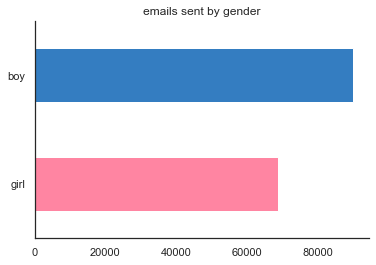

In [12]:
p = df.copy()
p = p.groupby(['gender']).size() # return size agg for gender

one_axis_bar(p, 'emails sent by gender')

### Number of senders by gender

gender
boy     3277
girl    2594
dtype: int64


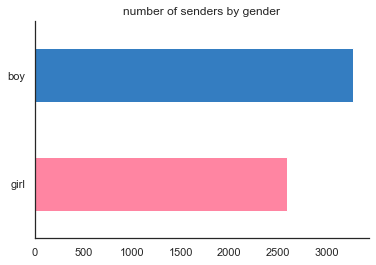

In [13]:
p = df.copy()
p = p.drop_duplicates('m_from').groupby(['gender']).size()

one_axis_bar(p, 'number of senders by gender')

### Emails sent each weekday

day_names
Sunday        3007
Monday       32120
Tuesday      33830
Wednesday    32375
Thursday     29855
Friday       25575
Saturday      1645
Name: 0, dtype: int64


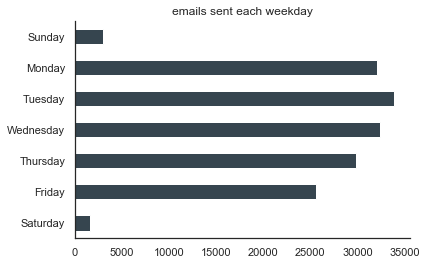

In [16]:
p = timf.loc['1998':].copy() # copy df
p = pd.DataFrame(p.groupby(['day_names']).size())[0].sort_index()  # groupby size, reindex

one_axis_barh(p, 'emails sent each weekday') # send to plotter

### Emails sent each weekday by gender

gender       boy   girl
day_names              
Sunday      2209    798
Monday     18166  13954
Tuesday    18698  15132
Wednesday  18293  14082
Thursday   16878  12977
Friday     14292  11283
Saturday    1249    396


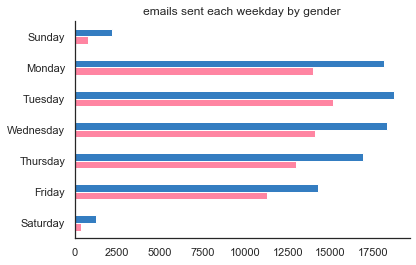

In [17]:
p = timf.loc['1998':].copy() # copy df
p = pd.DataFrame(p.groupby(['day_names', 'gender']).size()).unstack().reindex(labels=daylist)[0]

two_axes_barh(p, 'emails sent each weekday by gender')

### Emails sent each day by gender (normalized)

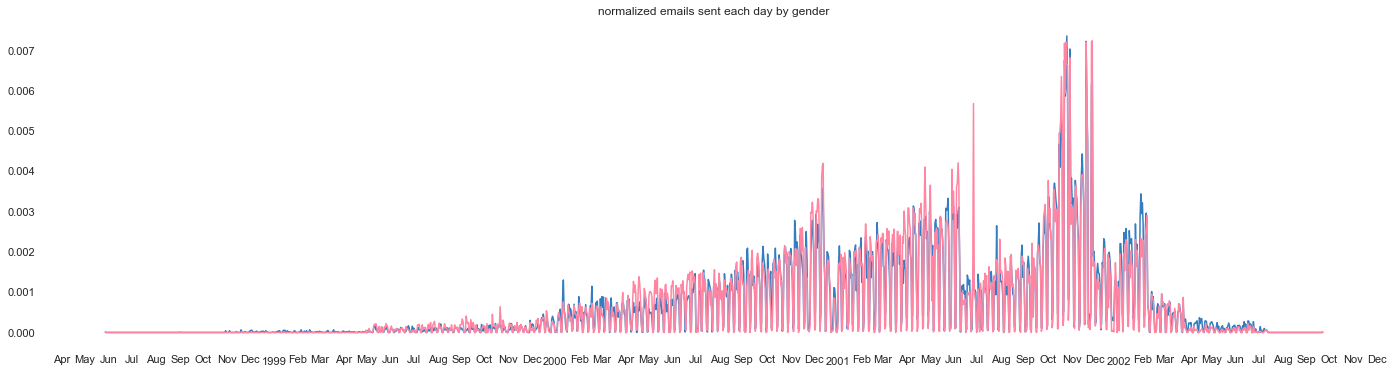

In [24]:
two_var_timeline(p, 'normalized emails sent each day by gender')

# Capstone Project 1: Preprocessing Data

In [1]:
import pandas as pd

In [2]:
gender_frame = pd.read_csv('./data/enron/01_got_gender.csv', index_col=0)

In [3]:
gender_frame.head()

,f_dir,m_id,m_date,m_from,m_to,m_cc,m_bcc,m_subj,mime_vers,cont_type,encode,x_from,x_to,x_cc,x_bcc,x_fold,x_orig,x_fname,m_body,gender
0,./data/maildir/allen-p/_sent_mail/1,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,tim.belden@enron.com,NaN,NaN,NaN,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,NaN,NaN,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst\n\n,Here is our forecast\n\n,boy
1,./data/maildir/allen-p/_sent_mail/10,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,john.lavorato@enron.com,NaN,NaN,Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,NaN,NaN,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst\n\n,Traveling to have a business meeting takes the...,boy
2,./data/maildir/allen-p/_sent_mail/100,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",phillip.allen@enron.com,leah.arsdall@enron.com,NaN,NaN,Re: test,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Leah Van Arsdall,NaN,NaN,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf\n\n,test successful. way to go!!!,boy
3,./data/maildir/allen-p/_sent_mail/1000,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",phillip.allen@enron.com,randall.gay@enron.com,NaN,NaN,NaN,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Randall L Gay,NaN,NaN,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf\n\n,"Randy,\n\n Can you send me a schedule of the s...",boy
4,./data/maildir/allen-p/_sent_mail/1001,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",phillip.allen@enron.com,greg.piper@enron.com,NaN,NaN,Re: Hello,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Greg Piper,NaN,NaN,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf\n\n,Let's shoot for Tuesday at 11:45.,boy


In [4]:
# get features (m_body), target (gender)
df = gender_frame[['m_body', 'gender']].copy()

In [5]:
df.head()

,m_body,gender
0,Here is our forecast\n\n,boy
1,Traveling to have a business meeting takes the...,boy
2,test successful. way to go!!!,boy
3,"Randy,\n\n Can you send me a schedule of the s...",boy
4,Let's shoot for Tuesday at 11:45.,boy


In [6]:
# return the largest email body for preprocessing setup
ts = df.m_body.max()
tss = df.loc[0:20, 'm_body']

In [7]:
tss

0                             Here is our forecast\n\n 
1     Traveling to have a business meeting takes the...
2                        test successful.  way to go!!!
3     Randy,\n\n Can you send me a schedule of the s...
4                   Let's shoot for Tuesday at 11:45.  
5     Greg,\n\n How about either next Tuesday or Thu...
6     Please cc the following distribution list with...
7                      any morning between 10 and 11:30
8     1. login:  pallen pw: ke9davis\n\n I don't thi...
9     ---------------------- Forwarded by Phillip K ...
10    Mr. Buckner,\n\n For delivered gas behind San ...
11    Lucy,\n\n Here are the rentrolls:\n\n\n\n Open...
12    ---------------------- Forwarded by Phillip K ...
13    ---------------------- Forwarded by Phillip K ...
14    Dave, \n\n Here are the names of the west desk...
15             Paula,\n\n 35 million is fine\n\nPhillip
16    ---------------------- Forwarded by Phillip K ...
17    Tim,\n\nmike grigsby is having problems wi

In [11]:
# import regex
import regex as re

# import lemmatizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize # creates tokenized words
from nltk.corpus import stopwords


# instantiate stemmer object
stemmer = WordNetLemmatizer()

# catch list
results = []

def process_text(ts):
    ts = re.sub(r'\W', ' ', str(ts)) # remove characters that are not word characters
    ts = re.sub(r'_+', ' ', str(ts), flags=re.I) # removes the underscore character
    ts = re.sub(r'\s+[a-zA-Z]\s+|\^[a-zA-Z]\s+', ' ', str(ts)) # removes all single characters
    ts = re.sub(r'\d', ' ', str(ts)) # removes numbers
    ts = ts.lower()
    ts = re.sub(r'\s+', ' ', str(ts), flags=re.I) # reduces multiple spaces to single space
    
    # lemmatization
    words = word_tokenize(ts)
    ts = [stemmer.lemmatize(word) for word in words]
    ts = ' '.join(ts)
    
    return ts

In [17]:
%%time
df['p_body'] = df.m_body.apply(process_text)
processed_body = df.copy()
processed_body = processed_body.drop('m_body', axis=1)
processed_body.to_csv('./data/enron/02_preprocessed_body.csv')

Wall time: 29min 45s


# Capstone Project 1: Filtering Dataset

In [1]:
# import pandas
import pandas as pd
# viewing options
pd.set_option('max_colwidth', 100)

In [2]:
%%time
# import dataframe, drop duplicates
df = pd.read_csv('./data/enron/03_processed_body.csv', index_col=0)
df.groupby(['gender']).size()

Wall time: 6.71 s


gender
boy     235804
girl    174119
dtype: int64

### Monitoring impact on label
We want to keep an eye on the male/female ratio when filtering out our dataset (especially when blanket removing things like 'duplicates', where the filtering can be applied to either label for the same condition) so that our label ratio isn't significantly unbalanced as a result.

In [3]:
def monitor_label(df):
    b = df.groupby(['gender']).size().boy
    g = df.groupby(['gender']).size().girl
    print('Frame Size: {}, B/G Ratio: {:.3f}'.format(b+g, b/g))
    
monitor_label(df)

Frame Size: 409923, B/G Ratio: 1.354


### Remove NaN from gender, email

In [4]:
# set dataframe to not NaN gender returns
df = df[df.gender.notna()]

# return index of NaN email body
_ = df[df.p_body.isna()].index

# drop NaN body
df = df.drop(_)

monitor_label(df)

Frame Size: 409719, B/G Ratio: 1.354


### Remove duplicate emails from body

In [5]:
# set dataframe to dropped duplicates
df = df.drop_duplicates('p_body')

monitor_label(df)

Frame Size: 182823, B/G Ratio: 1.315


### Reset index
Prior to using the indices and indexes to reference data in the dataframe, we'll need to reset the index so the values line up.

In [6]:
# reindex dataframe for cosine similarity matching
df = df.reset_index(drop=True)

## Cosine similarity (cossim) to find near-duplicate items
Here we'll use cosine similarity scores across samples from our population to review for filtering criteria. Because we're working with limited memory, we'll take a sample from the dataframe, transform it with tfidf, and calculate the cossim score.    

Once the cossim matrix is returned for all documents in the corpus, we'll get a list of the indices where cossim score is greater than ~90-95% and filter the dataframe by indexing the indice returns. **This will return a subset of the sample with high cossim.**    

Finally, we'll fit the data with a Multinomial Naive Bayes model to identify features from the dataset for review.

### Use Cosine Similarity (cossim) to evaluate identical email body items

In [7]:
%%time
# import numpy
import numpy as np

# viewing options
np.set_printoptions(edgeitems=10)
np.core.arrayprint._line_width = 300

# user function
def cos_sim_this(df, p=0.95, n=10000):
    """input a dataframe, cos sim %, and sample number
       return a filtered dataframe of the cos sim results"""
    # reset index (needs full, linear index or will throw flag)
    df = df.reset_index(drop=True)
    
    # collect a sample
    sample = df.sample(n, random_state=42)

    # feature extraction - tfidf
    from sklearn.feature_extraction.text import TfidfVectorizer
    tf_vect = TfidfVectorizer()
    tfidf = tf_vect.fit_transform(sample.p_body)

    # pairwise - cosine similarity
    from sklearn.metrics.pairwise import cosine_similarity
    cos = cosine_similarity(tfidf) # return pairwise similarities between all samples in input (Note: can be sliced [0:1000])

    # make a list of array indices that match our cos % condition for dataframe indexing
    idx_list = []
    for doc_ind in np.arange(len(cos)):
        doc_tup = np.where(cos[doc_ind] > p)
        if len(doc_tup[0]) > 1:
            x = doc_tup[0]
            idx_list.append(x[x != doc_ind][0])
    idx_list = list(set(idx_list))

    # get high cossim selection from original df (by index)
    filter_df = df.loc[idx_list, :]
    
    return filter_df


# call function
initial_sample = cos_sim_this(df, p=0.9, n=20000)

Wall time: 33.2 s


### Using a model to identify features for filtering

### Vectorize input data
We'll use a Tfidf vectorizer to transform the text here because we're interested in identifying 'features' across our subsample with high cosine similarity to identify any keywords that can help with filtering out mass almost-perfect duplicates that would skew our dataset (ex. FW:, RE:, spam, etc).

### Reviewing 'forwarded by'

In [8]:
%%time

# create stopwords list
from nltk.corpus import stopwords

# set stopwords list to english
stop_words = set(stopwords.words('english'))


def check_feature_perc(s, a_df):
    ft_len = len(a_df[a_df.p_body.str.contains(s)])
    df_len = len(a_df)
    return (ft_len/df_len)*100


def get_features(df, n=10, ngrams=(1,1), transform='t', stop_words=stop_words):
    # get variables for model
    Xf = df.p_body.values
    yf = np.zeros((len(Xf)), np.int8) # dumbie label '0'

    # instantiate, fit transformer
    if transform == 't':
        from sklearn.feature_extraction.text import TfidfVectorizer
        tf_vect = TfidfVectorizer(analyzer='word', ngram_range=ngrams, stop_words=stop_words)
        X_t = tf_vect.fit_transform(Xf)
        v = tf_vect
    
    # instantiate, fit vectorizer
    if transform == 'c':
        from sklearn.feature_extraction.text import CountVectorizer
        c_vect = CountVectorizer(analyzer='word', ngram_range=ngrams, stop_words=stop_words)
        X_t = c_vect.fit_transform(Xf)
        v = c_vect

    # import model
    from sklearn.naive_bayes import MultinomialNB

    # instantiate model object
    mnb = MultinomialNB()

    # fit model on data
    mnb.fit(X_t, yf)

    # return features by coefs
    def show_most_informative_features(vectorizer, clf, n=n):
        feature_names = vectorizer.get_feature_names()
        coefs_with_fns = sorted(zip(clf.coef_[0], feature_names), reverse=True)
        top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
        print('Most Informative Features\n(coef score, % of df has feature, feature string)\n')
        for (coef_1, fn_1), (coef_2, fn_2) in top:
            p_1 = check_feature_perc(fn_1, df)
            print('{:.3f} {:.0f}% {}'.format(coef_1, p_1, fn_1))
            
            #p_2 = check_feature_perc(fn_2, df)
            #print('{:.0f}% {} {:.3f}\t\t{:.0f}% {} {:.3f}'.format(p_1, fn_1, coef_1, p_2, fn_2, coef_2))
            # print('{:.3f} {}, {:.3f} {}'.format(coef_1, fn_1, coef_2, fn_2))

    show_most_informative_features(v, mnb)
    

# call function
get_features(initial_sample, n=20, transform='t', ngrams=(4,4))

Most Informative Features
(coef score, % of df has feature, feature string)

-9.593 12% hou ect ect cc
-9.741 9% ect ect cc subject
-10.152 4% eric bass hou ect
-10.289 5% sally beck hou ect
-10.316 3% bass hou ect ect
-10.380 4% enron north america corp
-10.404 3% john arnold hou ect
-10.410 4% enron com cc subject
-10.433 2% wireless handheld www blackberry
-10.433 0% sent blackberry wireless handheld
-10.433 2% handheld www blackberry net
-10.433 2% blackberry wireless handheld www
-10.482 0% original message arnold john
-10.489 4% hou ect ect subject
-10.489 2% arnold hou ect ect
-10.494 0% message arnold john sent
-10.497 2% phillip allen hou ect
-10.508 4% beck hou ect ect
-10.610 2% eric bass enron com
-10.661 3% thanks lynn original message
Wall time: 1.92 s


### Adding to stop words list

In [9]:
# create a new stop words list that includes 'enron', 'ect', 'hou', 'phillip allen', 'eric bass', 'arnold john'
add_stops = ['enron', 'ect', 'hou', 'phillip', 'allen', 'eric', 'bass', 'arnold', 'john', 'com']
new_stops = list(stop_words) + add_stops
new_stops = set(new_stops)

# call function
get_features(initial_sample, n=20, transform='t', ngrams=(2,5), stop_words=new_stops)

Most Informative Features
(coef score, % of df has feature, feature string)

-10.796 33% original message
-11.151 19% cc subject
-11.160 0% let know
-11.595 10% would like
-11.659 9% sent monday
-11.709 8% sent tuesday
-11.740 8% please let
-11.773 7% sally beck
-11.773 0% please let know
-11.777 8% sent thursday
-11.851 6% october pm
-11.876 7% sent wednesday
-11.884 4% http www
-11.894 8% subject fw
-11.934 6% sent friday
-11.959 5% north america
-11.970 5% blair lynn
-12.013 3% michelle cash
-12.042 4% thanks lynn
-12.060 0% pm cc


### Review email phrases
Here, we're going to pass phrases back to the cossim calculator and return the % of emails that meet the cossim threshold, relative to the overall number of emails in the sample. We'll use a lower threshold to amplify the significance of each phrase.

In [10]:
def cosine_by_phrases(s, n=10000, p=0.8):
    
    first_sample = cos_sim_this(df=df, p=p, n=n)
    print('% of sample frame that meets cosim threshold: {:.0f}%\n'.format(len(first_sample)*100/n))
    
    for phrase in s:
        cond = df.p_body.str.contains(phrase)
        df_filt = df[cond]
        second_sample = cos_sim_this(df=df_filt, p=p, n=n)
        
        print("'{}' filter: {:.0f}%".format(phrase, len(second_sample)*100/n))

In [11]:
s = ['cc subject', 'original message', 'forwarded by', 'subject fw']
cosine_by_phrases(s)

% of sample frame that meets cosim threshold: 6%

'cc subject' filter: 18%
'original message' filter: 20%
'forwarded by' filter: 20%
'subject fw' filter: 35%


> From a random sample of 10,000 emails pulled from our dataset, **35%** of the sample meets the cossim threshold when filtered by the phrase **'subject fw'** versus 6% returned by a control sample.

In [12]:
cosine_by_phrases(s, p=.95)

% of sample frame that meets cosim threshold: 3%

'cc subject' filter: 10%
'original message' filter: 11%
'forwarded by' filter: 12%
'subject fw' filter: 29%


> Even when we increase the cossim threshold, the phrase **'subject fw'** still returns **29%** meeting the cossim threshold, compared to only 3% from a control sample.

### Checking the impact of filters

In [13]:
n = 20000
p = .95

# none filtered
a_sample = cos_sim_this(df=df, p=p, n=n)
print("0 filters: {:.0f}%".format(len(a_sample)*100/n))
print(monitor_label(df))
print('')

# check impact of removing 1 phrase
cond = (df.p_body.str.contains('subject fw'))
f_df = df[~cond]
a_sample = cos_sim_this(df=f_df, p=p, n=n)
print("1 filter('subject fw'): {:.0f}%".format(len(a_sample)*100/n))
print(monitor_label(f_df))
print('')

# check impact of removing 1 phrase
cond = (df.p_body.str.contains('original message'))
f_df = df[~cond]
a_sample = cos_sim_this(df=f_df, p=p, n=n)
print("1 filter('original message'): {:.0f}%".format(len(a_sample)*100/n))
print(monitor_label(f_df))
print('')

# check impact of removing 1 phrase
cond = (df.p_body.str.contains('forwarded by'))
f_df = df[~cond]
a_sample = cos_sim_this(df=f_df, p=p, n=n)
print("1 filter('forwarded by'): {:.0f}%".format(len(a_sample)*100/n))
print(monitor_label(f_df))
print('')

# check impact of removing 1 phrase
cond = (df.p_body.str.contains('cc subject'))
f_df = df[~cond]
a_sample = cos_sim_this(df=f_df, p=p, n=n)
print("1 filter('cc subject'): {:.0f}%".format(len(a_sample)*100/n))
print(monitor_label(f_df))
print('')

# check impact of removing all phrases
cond = (df.p_body.str.contains('subject fw') | df.p_body.str.contains('forwarded by') | df.p_body.str.contains('original message') | df.p_body.str.contains('cc subject'))
f_df = df[~cond]
a_sample = cos_sim_this(df=f_df, p=p, n=n)
print(monitor_label(f_df))
print("4 filters: {:.0f}%\n".format(len(a_sample)*100/n))

0 filters: 4%
Frame Size: 182823, B/G Ratio: 1.315
None

1 filter('subject fw'): 4%
Frame Size: 169560, B/G Ratio: 1.303
None

1 filter('original message'): 3%
Frame Size: 131472, B/G Ratio: 1.227
None

1 filter('forwarded by'): 4%
Frame Size: 149053, B/G Ratio: 1.327
None

1 filter('cc subject'): 4%
Frame Size: 144231, B/G Ratio: 1.321
None

Frame Size: 90085, B/G Ratio: 1.222
None
4 filters: 2%



> Though **subject fw** has the higher similarity scores when isolated, the frequency of the phrase across the dataset is low - mitigating the influence of possible duplicates.    
> 
> When we apply each filter individually, there isn't a significant reduction in the cos sim score, relative to the reduction across the dataset. When we apply all 4 filters, both the dataset size and cosim % are reduced roughly the same amount.

# Capstone Project 1: Modeling Data

In [3]:
# imports
import numpy as np
import pandas as pd

# set data to df
df = pd.read_csv('./data/enron/03_filtered_dataset.csv', index_col=0)

In [4]:
df.head()

,gender,p_body
0,boy,here is our forecast
1,boy,traveling to have business meeting take the fu...
2,boy,test successful way to go
3,boy,randy can you send me schedule of the salary a...
4,boy,let shoot for tuesday at


In [5]:
df.groupby(['gender']).size()

gender
boy     103852
girl     78971
dtype: int64

## Exploratory data analysis

In [6]:
## 

## Reclassify data

In [7]:
# bool target variables: boy = 0, girl = 1
df.gender = df.gender.replace('boy', 0)
df.gender = df.gender.replace('girl', 1)

In [8]:
# reclassify data into arrays
full_X = df.p_body.values # features
full_y = df.gender.values # targets (gender labels)

## Multi-class classifier

In [9]:
def plot_multi(X, y, n_samples=1000, CV=5):
    
    # import numpy
    import numpy as np
    
    # random choice collect index
    sample_idx = np.random.choice(np.arange(len(X)), size=n_samples, replace=True)

    # create sample subsets
    Xs = X[sample_idx]
    ys = y[sample_idx]
    
    
    # import tfidfvectorizer
    from sklearn.feature_extraction.text import TfidfVectorizer
    t_vect = TfidfVectorizer()
    
    # transform data
    Xs_tfidf = t_vect.fit_transform(Xs)


    # import model selection
    from sklearn.model_selection import train_test_split
    
    # Create train and test sets
    Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs_tfidf, ys, test_size=0.4, random_state=42)

    
    # import models
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.linear_model import LogisticRegression
    from sklearn.linear_model import SGDClassifier
    from sklearn.svm import LinearSVC
    from sklearn.neighbors import KNeighborsClassifier

    # import model selection
    from sklearn.model_selection import cross_val_score

    # create models object
    models = [
        RandomForestClassifier(max_depth=25, random_state=42),
        MultinomialNB(),
        LogisticRegression(random_state=42),
        SGDClassifier(),
        LinearSVC(),
        KNeighborsClassifier(),
    ]
    
    # create dataframe, list for data catch
    cv_df = pd.DataFrame(index=range(CV * len(models)))
    entries = []

    # name dict
    name_dict = {
        'RandomForestClassifier':'RFC',
        'LinearSVC': 'LSVC',
        'MultinomialNB':'MNBayes',
        'LogisticRegression':'Logreg',
        'SGDClassifier':'SGDC',
        'KNeighborsClassifier':'KNNc',
    }
    
    # loop models
    for model in models:
        model_name = name_dict[model.__class__.__name__]
        #model_name = model.__class__.__name__
        accuracies = cross_val_score(model, Xs_train, ys_train, scoring='accuracy', cv=CV, n_jobs=-1)
        for fold_idx, accuracy in enumerate(accuracies):
            entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

    # import seaborn
    import seaborn as sns
    # visual formatting
    sns.set(style='white')
    import matplotlib.pyplot as plt
    # figure size
    from matplotlib.pyplot import figure
    figure(figsize=(6, 4), facecolor='w', edgecolor='k')

    # create seaborn plot
    # sns.boxplot(x='model_name', y='accuracy', data=cv_df)
    sns.boxplot(x='model_name', y='accuracy', data=cv_df)
    sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
                  size=8, jitter=True, edgecolor="gray", linewidth=2)
    
    plt.title('n_samples: {}'.format(n_samples))
    plt.grid(axis='y', which='both')
    plt.xlabel('Classifiers')
    plt.show()

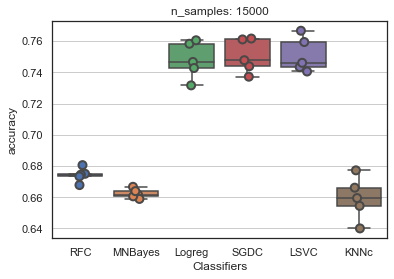

Wall time: 16.5 s


In [10]:
%%time
# Evaluating Classifiers
plot_multi(full_X, full_y, n_samples=15000)

## Variance across sample count

In [11]:
def plot_few(X, y, n_samples=1000, CV=5):
    
    # import numpy
    import numpy as np
    
    # random choice collect index
    sample_idx = np.random.choice(np.arange(len(X)), size=n_samples, replace=True)

    # create sample subsets
    Xs = X[sample_idx]
    ys = y[sample_idx]
  
    # import tfidfvectorizer
    from sklearn.feature_extraction.text import TfidfVectorizer
    t_vect = TfidfVectorizer()
    
    # transform data
    Xs_tfidf = t_vect.fit_transform(Xs)

    
    # import model selection
    from sklearn.model_selection import train_test_split
    
    # Create train and test sets
    Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs_tfidf, ys, test_size=0.4, random_state=42)

    # import models
    from sklearn.linear_model import LogisticRegression
    from sklearn.linear_model import SGDClassifier
    from sklearn.svm import LinearSVC

    # import model selection
    from sklearn.model_selection import cross_val_score

    # create models object
    models = [
        LogisticRegression(random_state=42),
        SGDClassifier(),
        LinearSVC(),
    ]
    
    # create dataframe, list for data catch
    cv_df = pd.DataFrame(index=range(CV * len(models)))
    entries = []

    # name dict
    name_dict = {
        'RandomForestClassifier':'RFC',
        'LinearSVC': 'LSVC',
        'MultinomialNB':'MNBayes',
        'LogisticRegression':'Logreg',
        'SGDClassifier':'SGDC',
        'KNeighborsClassifier':'KNNc',
    }
    
    # loop models
    for model in models:
        model_name = name_dict[model.__class__.__name__]
        #model_name = model.__class__.__name__
        accuracies = cross_val_score(model, Xs_train, ys_train, scoring='accuracy', cv=CV, n_jobs=-1)
        for fold_idx, accuracy in enumerate(accuracies):
            entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

    # import seaborn
    import seaborn as sns
    # visual formatting
    sns.set(style='white')
    import matplotlib.pyplot as plt
    # figure size
    from matplotlib.pyplot import figure
    figure(figsize=(4, 4), facecolor='w', edgecolor='k')

    # create seaborn plot
    # sns.boxplot(x='model_name', y='accuracy', data=cv_df)
    sns.boxplot(x='model_name', y='accuracy', data=cv_df)
    sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
                  size=8, jitter=True, edgecolor="gray", linewidth=2)
    
    plt.title('n_samples: {}'.format(n_samples))
    plt.grid(axis='y', which='both')
    plt.xlabel('Classifiers')
    plt.show()

[ 60000  90000 120000 150000 180000]


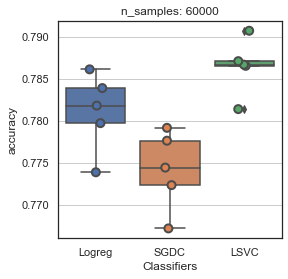

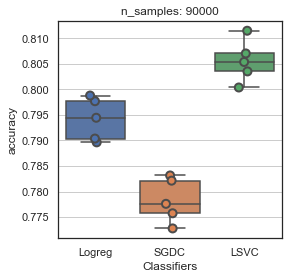

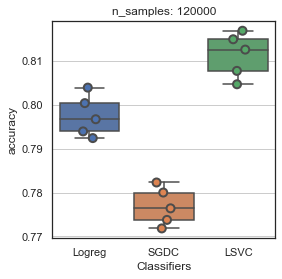

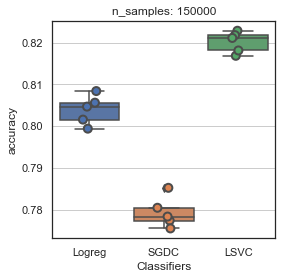

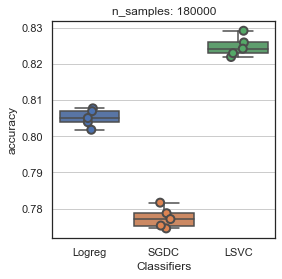

Wall time: 2min 56s


In [12]:
%%time

# numpy
import numpy as np

# review model variation relative to sample input
sample_nums = np.arange(60000, 180001, 30000)
print(sample_nums)

# run charts
for ct in sample_nums:
    plot_few(full_X, full_y, n_samples=ct, CV=5)

> Stochastic Gradient Descent Classifier (SGDC) should have zero mean and unit variance for best performance. For now, we'll stay with Linear SVC.